In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


# Continuous X

In [14]:
s, x,z,y= generate_data_longitudinl(n=1000,T=5,C_coeff=0.01)
# print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)

model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=3000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 8.1664,	loss_y 6.0703, 6.1208, 0.1009,	loss_eta 2.0961, 2.1862, 0.1801
Epoch 1000: loss 3.3612,	loss_y 1.8545, 3.7615, 3.8140,	loss_eta 1.5067, 3.0141, 3.0148
Epoch 2000: loss 3.2696,	loss_y 1.7704, 3.6085, 3.6761,	loss_eta 1.4992, 2.9695, 2.9408
Epoch 3000: loss 3.2009,	loss_y 1.6825, 3.2807, 3.1965,	loss_eta 1.5184, 2.9209, 2.8051


In [15]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*5],dtype=torch.int32),
                                            sample_size=1000)

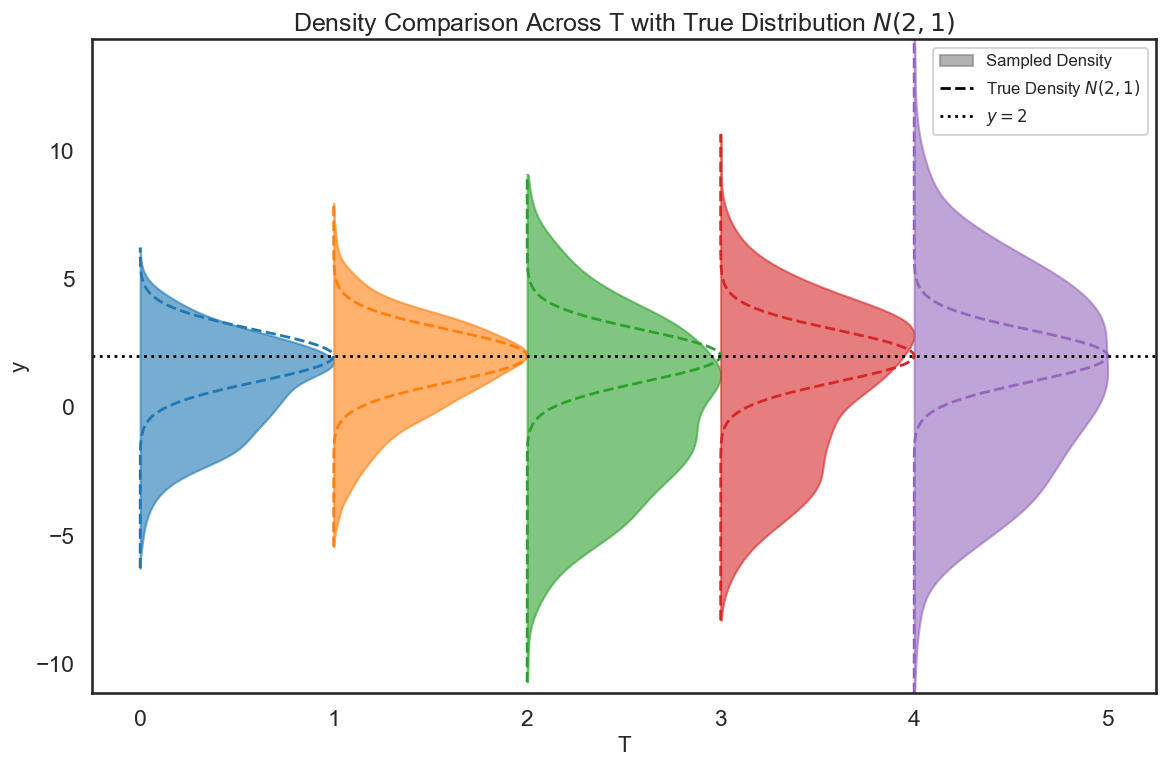

In [16]:
# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

# Trouble-shooting: adding C in data sampling and enable C in model fitting for y

## Include c in prediction

In [10]:
s, x,z,y= generate_data_longitudinl(n=10000,T=5,C_coeff=0.01)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)


2.074362213371984


In [11]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 5.6080,	loss_y 3.5526, 3.5896, 0.0741,	loss_eta 2.0554, 2.1382, 0.1656
Epoch 1000: loss 2.9653,	loss_y 1.4515, 2.9148, 2.9266,	loss_eta 1.5138, 2.9972, 2.9667
Epoch 2000: loss 2.9419,	loss_y 1.4489, 2.8969, 2.8960,	loss_eta 1.4930, 2.9901, 2.9942
Epoch 3000: loss 2.9502,	loss_y 1.4493, 2.9009, 2.9032,	loss_eta 1.5008, 2.9907, 2.9797
Epoch 4000: loss 2.9658,	loss_y 1.4479, 2.8911, 2.8865,	loss_eta 1.5179, 3.0000, 2.9641


In [43]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*5],dtype=torch.int32),
                                            sample_size=1000)

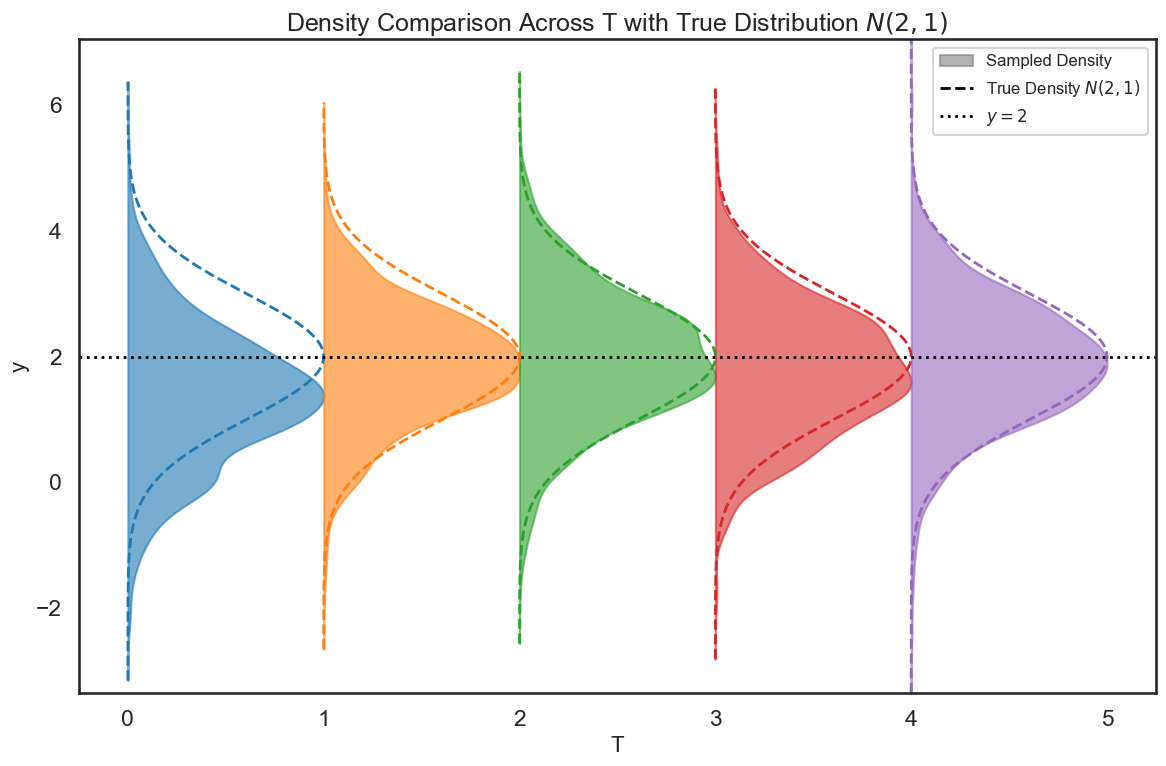

In [44]:
# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

## Sanity check on fengression of last step

In [21]:
s, x,z,y= generate_data_longitudinl(n=6000,T=5,C_coeff=0)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y[:,4:5], dtype=torch.float32)
z_tr = torch.concat([s_tr,torch.tensor(z, dtype=torch.float32)],dim=1)

2.079299373635628


In [22]:
fr_model = Frengression(
        x_dim=x_tr.shape[1], y_dim=y_tr.shape[1], z_dim=z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=True
    )
fr_model.train_y(x=x_tr, z=z_tr, y=y_tr, num_iters=8000, lr=1e-4, print_every_iter=400)


Epoch 1: loss 2.0888,	loss_y 1.3191, 1.3268, 0.0152,	loss_eta 0.7696, 0.7967, 0.0541
Epoch 400: loss 1.1322,	loss_y 0.5676, 1.1190, 1.1028,	loss_eta 0.5647, 1.0953, 1.0612
Epoch 800: loss 1.1014,	loss_y 0.5501, 1.0973, 1.0944,	loss_eta 0.5513, 1.1021, 1.1017
Epoch 1200: loss 1.1044,	loss_y 0.5325, 1.0784, 1.0919,	loss_eta 0.5719, 1.1179, 1.0921
Epoch 1600: loss 1.1118,	loss_y 0.5432, 1.0812, 1.0761,	loss_eta 0.5686, 1.1204, 1.1035
Epoch 2000: loss 1.0989,	loss_y 0.5411, 1.0840, 1.0859,	loss_eta 0.5578, 1.1121, 1.1086
Epoch 2400: loss 1.1128,	loss_y 0.5357, 1.0800, 1.0886,	loss_eta 0.5771, 1.1252, 1.0962
Epoch 2800: loss 1.0987,	loss_y 0.5396, 1.0745, 1.0699,	loss_eta 0.5591, 1.1182, 1.1181
Epoch 3200: loss 1.1153,	loss_y 0.5364, 1.0691, 1.0655,	loss_eta 0.5789, 1.1360, 1.1141
Epoch 3600: loss 1.0894,	loss_y 0.5326, 1.0716, 1.0780,	loss_eta 0.5568, 1.1129, 1.1121
Epoch 4000: loss 1.0874,	loss_y 0.5323, 1.0655, 1.0666,	loss_eta 0.5551, 1.1082, 1.1061
Epoch 4400: loss 1.0829,	loss_y 0.529

In [40]:
y_margin_sample = fr_model.sample_causal_margin(x=torch.tensor([[1,1,1,1,1]]),sample_size=5000)

Text(0.5, 1.0, 'Engression for last step, $\\bar{X}=1$')

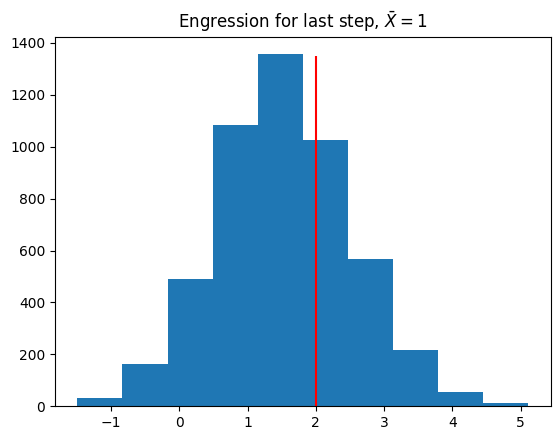

In [43]:
plt.hist(y_margin_sample[0][0])
plt.vlines(x=2,ymin=0,ymax=1350,colors="red")
plt.title(r"Engression for last step, $\bar{X}=1$")

## Sanity check: incoporate S in predicition inptut

In [78]:
s, x,z,y= generate_data_longitudinl(n=10000,T=3,C_coeff=0.5)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)

2.18578881832818


In [79]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=8000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.3222,	loss_y 2.7844, 2.8235, 0.0781,	loss_eta 1.5377, 1.6069, 0.1384
Epoch 1000: loss 2.2323,	loss_y 1.0883, 2.1799, 2.1831,	loss_eta 1.1440, 2.2614, 2.2350
Epoch 2000: loss 2.2076,	loss_y 1.0829, 2.1701, 2.1744,	loss_eta 1.1247, 2.2585, 2.2676
Epoch 3000: loss 2.2074,	loss_y 1.0791, 2.1715, 2.1846,	loss_eta 1.1282, 2.2461, 2.2358
Epoch 4000: loss 2.2202,	loss_y 1.0848, 2.1711, 2.1727,	loss_eta 1.1355, 2.2591, 2.2473
Epoch 5000: loss 2.2140,	loss_y 1.0869, 2.1729, 2.1720,	loss_eta 1.1271, 2.2559, 2.2575
Epoch 6000: loss 2.2093,	loss_y 1.0772, 2.1621, 2.1699,	loss_eta 1.1321, 2.2496, 2.2350
Epoch 7000: loss 2.2038,	loss_y 1.0762, 2.1605, 2.1687,	loss_eta 1.1276, 2.2440, 2.2329
Epoch 8000: loss 2.2083,	loss_y 1.0768, 2.1553, 2.1570,	loss_eta 1.1315, 2.2491, 2.2351


In [73]:
s=torch.tensor([[1]]),

tensor([-0.3895])

In [74]:
y_margin_sample = model.sample_causal_margin(s=torch.tensor([[0]]), x=torch.tensor([[1,1,1]], dtype=torch.int32),sample_size=5000)

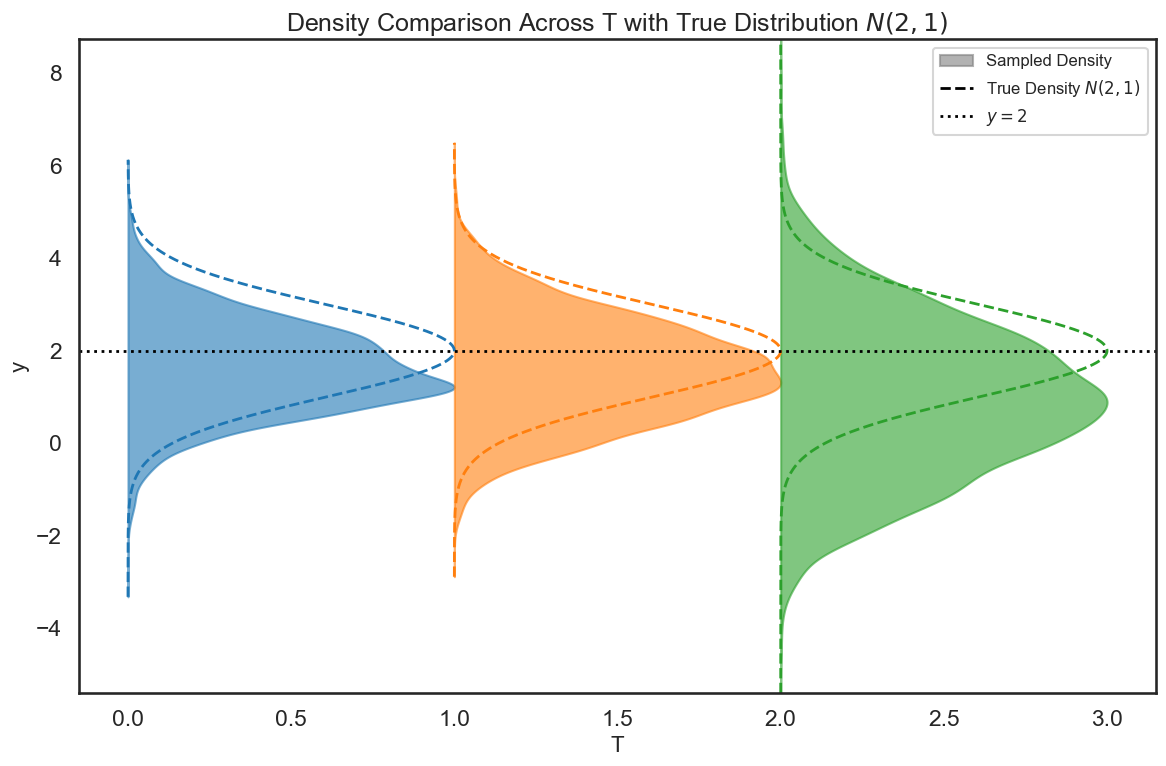

In [75]:


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(3)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


# Experiment: no C included in frengressionseq
The experiment results below were done when C( or s) is not included in the design of Frengressionseq. In particular, C( or s) is not used in y sampling / prediction.

## joint time trajectory

In [2]:
s, x,z,y= generate_data_survivl(n=30000,T=5)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

2.0909338076738213


In [3]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=6000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 5.5437,	loss_y 3.4944, 3.5384, 0.0880,	loss_eta 2.0492, 2.1346, 0.1708
Epoch 1000: loss 2.9736,	loss_y 1.4667, 2.9312, 2.9289,	loss_eta 1.5069, 2.9905, 2.9672
Epoch 2000: loss 2.9709,	loss_y 1.4652, 2.9268, 2.9232,	loss_eta 1.5057, 2.9971, 2.9829
Epoch 3000: loss 2.9684,	loss_y 1.4679, 2.9295, 2.9231,	loss_eta 1.5005, 2.9939, 2.9869
Epoch 4000: loss 2.9674,	loss_y 1.4634, 2.9316, 2.9364,	loss_eta 1.5040, 3.0076, 3.0071
Epoch 5000: loss 2.9677,	loss_y 1.4615, 2.9236, 2.9241,	loss_eta 1.5061, 3.0052, 2.9981
Epoch 6000: loss 2.9666,	loss_y 1.4616, 2.9313, 2.9394,	loss_eta 1.5050, 2.9975, 2.9849


In [4]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

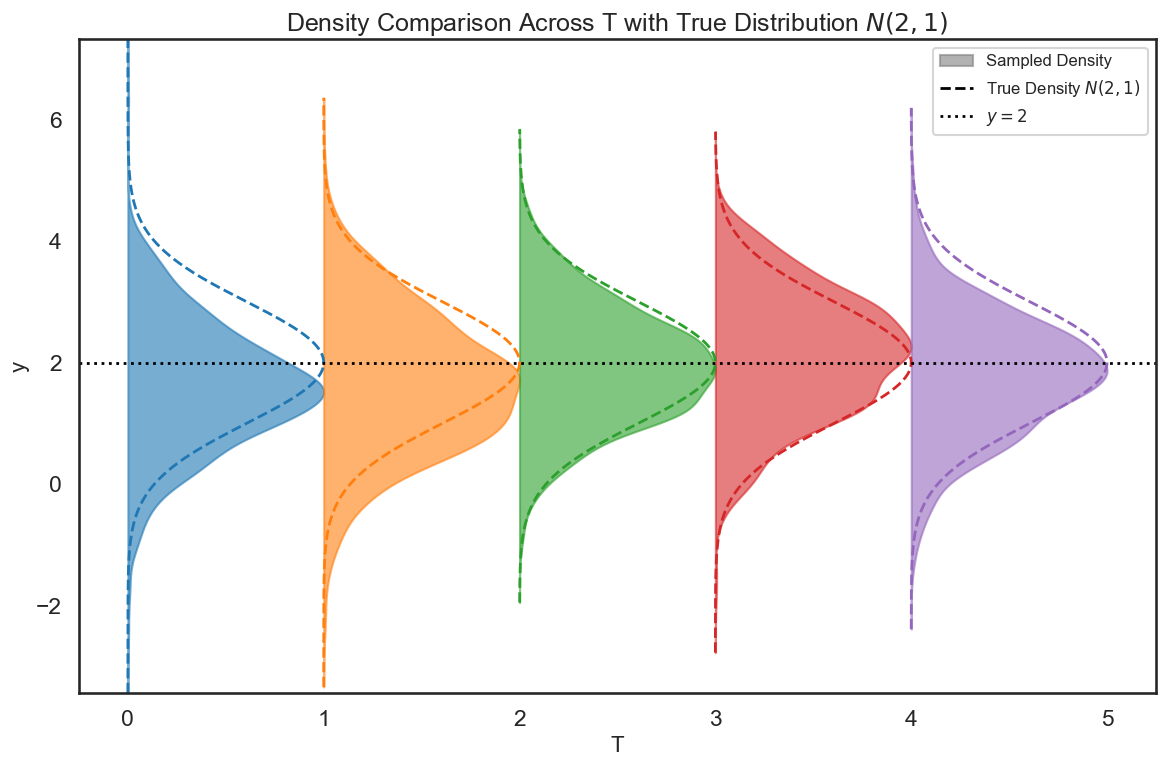

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


In [7]:
s, x,z,y= generate_data_survivl(n=30000,T=10)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=8000, lr=1e-4, print_every_iter=1000)

2.0909338076738213
Epoch 1: loss 8.0583,	loss_y 5.0842, 5.1553, 0.1421,	loss_eta 2.9741, 3.0997, 0.2511
Epoch 1000: loss 4.3088,	loss_y 2.1291, 4.2484, 4.2386,	loss_eta 2.1797, 4.3538, 4.3480
Epoch 2000: loss 4.2984,	loss_y 2.1254, 4.2412, 4.2316,	loss_eta 2.1730, 4.3427, 4.3395
Epoch 3000: loss 4.2965,	loss_y 2.1118, 4.2236, 4.2236,	loss_eta 2.1847, 4.3517, 4.3339
Epoch 4000: loss 4.2854,	loss_y 2.1094, 4.2266, 4.2345,	loss_eta 2.1761, 4.3497, 4.3473
Epoch 5000: loss 4.2905,	loss_y 2.1123, 4.2234, 4.2223,	loss_eta 2.1782, 4.3393, 4.3221
Epoch 6000: loss 4.2896,	loss_y 2.1006, 4.2067, 4.2123,	loss_eta 2.1890, 4.3431, 4.3082
Epoch 7000: loss 4.2689,	loss_y 2.0857, 4.1842, 4.1969,	loss_eta 2.1832, 4.3365, 4.3067
Epoch 8000: loss 4.2655,	loss_y 2.0784, 4.1726, 4.1885,	loss_eta 2.1872, 4.3359, 4.2974


In [ ]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

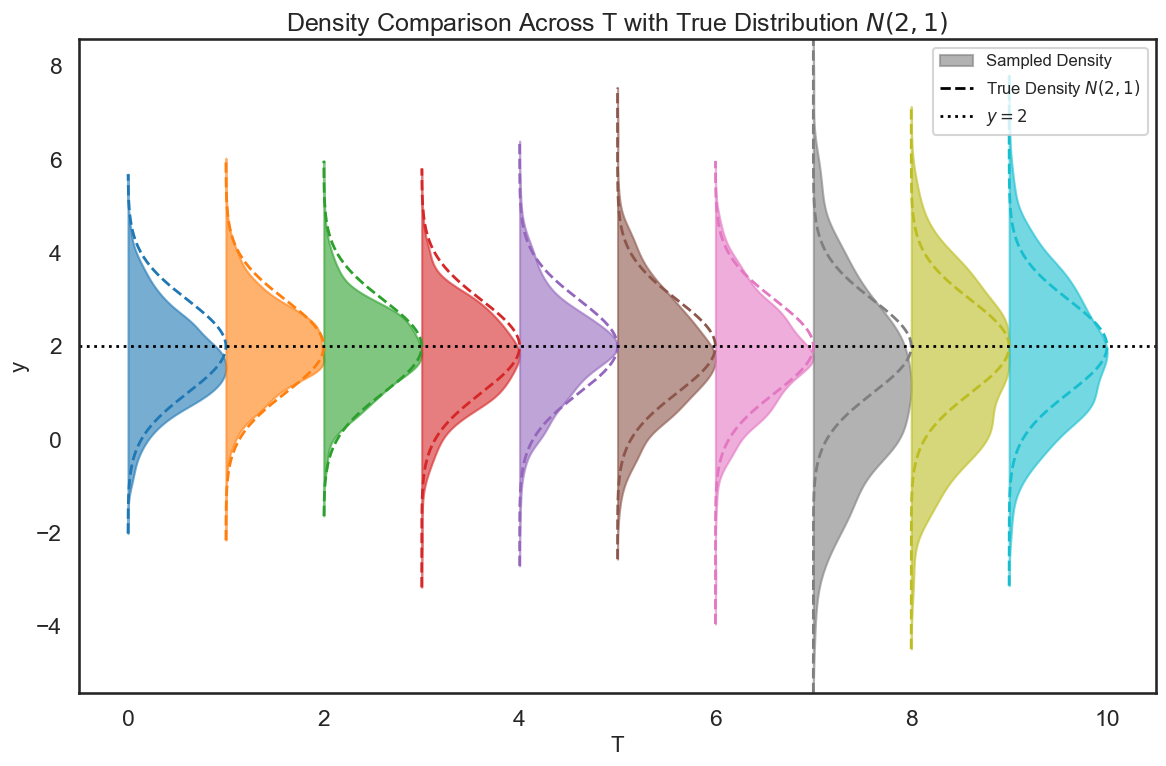

In [24]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1]*10]), sample_size=1000)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(10)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()
